# K-means: Profiling and optimization demo

Here is a more complex example, which shows a simple implementation, diagnosis, and reimplementation development workflow. In short, it walks you through the following:

1. A brief mathematical summary of Lloyd's algorithm for the k-means clustering problem.
2. An initial implementation, which was written by a student in [Georgia Tech's MS Analytics program](http://analytics.gatech.edu) as part of a homework assignment.
3. An invocation of Python's `line_profiler` tool to identify potential execution time bottlenecks.
4. A reimplementation of one those bottlenecks in Intrepydd.
5. An optional exercise for you to try improving a different bottleneck in the same code.

This example follows an earlier [toy problem](./003-profiling.ipynb).

**Scaffolding.** This example includes some auxiliary scaffolding code to help generate a sample dataset and visualize it, so you can focus on implementation basics. Take a moment to skim and run these cells now.

In [1]:
import numpy
import pandas

from auxiliary import gen_mixture_of_gaussians, visualize_clusters, count_matches

**Dataset.** The following cell generates a sample dataset, which is a two-class mixture of Gaussians.

There are 200000 2-dimensional points.
There are 2 classes: [0 1]

Coordinates of the first few points:
[[-0.37556938 -1.79555239]
 [ 0.56534377 -1.48292745]
 [-0.81291895 -2.42496683]
 [ 0.14218233 -0.43535007]
 [-0.4784206  -2.06160622]]
...

Class labels of those first few points: [0 1 0 0 0] ...


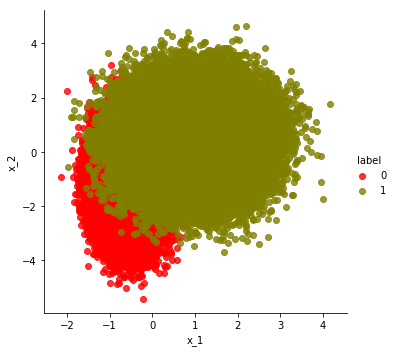

In [2]:
centers_true = numpy.array([[-0.5, -1],
                           [1.0, 0.5]])
covars_true = numpy.array([[[0.125, 0.0],
                            [0.0, 1.0]],
                           [[0.5, 0.0],
                            [0.0, 1.0]]])

points, labels = gen_mixture_of_gaussians(centers_true, covars_true, 100000)
n, d = points.shape
classes = numpy.unique(labels)
k = len(classes)

print("There are {} {}-dimensional points.".format(n, d))
print("There are {} classes: {}".format(k, classes))
print("\nCoordinates of the first few points:\n{}\n...".format(points[:5, :]))
print("\nClass labels of those first few points: {} ...".format(labels[:5]))

visualize_clusters(points, labels)

## Background: The $k$-means clustering criterion ##

Recall the $k$-means problem. You are giving a $m$ data points in a $d$-dimensional data points, denoted by the $m \times d$ matrix $X$. That is, let each data point be a $d$-dimensional column vector $x_i$ organized as follows:

$$
  X
  \equiv \left(\begin{array}{c} \hat{x}_0^T \\ \vdots \\ \hat{x}_{m}^T \end{array}\right)
  = \left(\begin{array}{ccc} x_0 & \cdots & x_{d-1} \end{array}\right).
$$

In the $k$-means problem, we hypothesize that these data may be divided into $k$ clusters.

For each cluster $C$, consider its center $\mu$ and measure the distance $\|x-\mu\|$ of each observation $x \in C$ to the center. Add these up for all points in the cluster; call this sum is the _within-cluster sum-of-squares (WCSS)_. Then, set as our goal to choose clusters that minimize the total WCSS over _all_ clusters.

More formally, given a clustering $C = \{C_0, C_1, \ldots, C_{k-1}\}$, let

$$
  \mathrm{WCSS}(C) \equiv \sum_{i=0}^{k-1} \sum_{x\in C_i} \|x - \mu_i\|^2,
$$

where $\mu_i$ is the center of $C_i$. This center may be computed simply as the mean of all points in $C_i$, i.e.,

$$
  \mu_i \equiv \dfrac{1}{|C_i|} \sum_{x \in C_i} x.
$$

Then, our objective is to find the "best" clustering, $C_*$, which is the one that has a minimum WCSS.

$$
  C_* = \arg\min_C \mathrm{WCSS}(C).
$$

**Lloyd's algorithm.** The standard $k$-means algorithm (also known as _Lloyd's algorithm_) is a heuristic iterative method for finding a local minimum for this optimization problem. (Finding the global optimum is [NP-hard](https://en.wikipedia.org/wiki/NP-hardness).) The procedure alternates between two operations: _assignment_ and _update_.

**Step 1: Assignment.** Given a fixed set of $k$ centers, assign each point to the nearest center:

$$
  C_i = \{\hat{x}: \| \hat{x} - \mu_i \| \le \| \hat{x} - \mu_j \|, 1 \le j \le k \}.
$$

**Step 2: Update.** Recompute the $k$ centers ("centroids") by averaging all the data points belonging to each cluster, i.e., taking their mean:

$$
  \mu_i = \dfrac{1}{|C_i|} \sum_{\hat{x} \in C_i} \hat{x}.
$$

## Initial code implementation ##

The following cells implement Lloyd's method. The data matrix $X$ is stored in the 2-D Numpy array, `points`, and the labels as a 1-D Numpy array, `labels`. Note that the k-means algorithm you will implement should **not** reference `labels` -- that's the solution this algorithm will try to predict given only the point coordinates (`points`) and target number of clusters (`k`).

**Step 0: Initialization.** To start the algorithm, you need an initial guess. Let's randomly choose $k$ observations from the data. The function, `init_centers(X, k)`, does so by randomly selecting $k$ of the given observations to serve as centers. It returns a Numpy array of size `k`-by-`d`, where `d` is the number of columns of `X`.

In [3]:
def init_centers(X, k, init_seed=1032742):
    """
    Randomly samples k observations from X as centers.
    Returns these centers as a (k x d) numpy array.
    """
    from numpy.random import choice, seed
    seed(init_seed)
    samples = choice(len(X), size=k, replace=False)
    return X[samples, :]

**Step 1: Computing squared-distances.** Given the $m \times d$ data `X` and a set of $k$ candidate centers `centers` (of size $k \times d$), the function `compute_d2(X, centers)` returns a $m \times k$ matrix $S$ whose $s_{ij}$ entry stores the _squared_ distance between each point $x_i$ and center $\mu_j$.

> The cell below first defines a function, `compute_d2__0()`, and then creates an alias `compute_d2`. You'll see why when you get to the exercise at the very bottom of this notebook.

In [4]:
def compute_d2__0(X, centers):
    return numpy.linalg.norm(X[:, numpy.newaxis, :] - centers, ord=2, axis=2) ** 2

compute_d2 = compute_d2__0

**Step 2: Re-assignment.** Given the $m \times k$ squared-distances as a 2-D Numpy array `S`, the function `assign_cluster_labels(S)` assigns each point to its closest center. The return is a 1-D array, `y`, whose `y[i]` entry indicates that point `X[i, :]` belongs to the cluster whose label is `y[i]`. By convention, the labels are integer values in the range of $[0, k-1]$.

In [5]:
def assign_cluster_labels(S):
    return numpy.argmin(S, axis=1)

**Step 3: Update centers.** Given the $m \times d$ data set `X` and $m$-vector of cluster assignments `y`, the function `update_centers__0(k, X, y)` determines the centroid $\mu_i$ of each cluster $0 \leq i < k$. The centroids are returned as an $k \times d$ array.

The code cell below further defines a variable, `update_centers`, which serves initially as an alias for `update_centers__0`. The reason is so that we can later redefine the alias to an Intrepydd version and easily compare different implementations by simply redefining `update_centers`.

In [6]:
def update_centers__0(k, X, y):
    # X[:m, :d] == m points, each of dimension d
    # y[:m] == cluster labels (max of k distinct labels, 0 through k-1)
    m, d = X.shape
    assert m == len(y), "Number of points ({}) and labels ({}) don't match.".format(m, len(y))
    assert (min(y) >= 0), "Labels must be positive."
    assert (max(y) < k), "Labels must be between 0 and {}, inclusive.".format(0, k-1)
    centers = numpy.zeros((k, d))
    for j in range(k):
        centers[j, :d] = numpy.mean(X[y == j, :], axis=0)
    return centers

update_centers = update_centers__0

**Step 4: Calculating the within-cluster-sum-of-squares metric.** To verify the progress of the method, the following function will help compute the within-cluster-sum-of-squared distances, given the squared-distances matrix `S` as defined above.

In [7]:
def WCSS(S):
    return numpy.sum(numpy.amin(S, axis=1))

**Step 5: Convergence testing.** Lastly, to determine whether we can terminate the method, here is a simple function that tests whether two sets of center values are equal or not. Note that this implementation uses Python sets so that it does not depend on the ordering of the centroids.

In [8]:
def has_converged(old_centers, centers):
    return set([tuple(x) for x in old_centers]) == set([tuple(x) for x in centers])

**Putting it all together.** From the six building blocks above, here is the entire implementation of Lloyd's algorithm. It accepts the dataset `X`, a target number of clusters `k`, and two optional arguments: the initial centers (`starting_centers`) and the maximum number of iteration steps (`max_steps`). Following the definition of this function is some code that executes the algorithm.

In [9]:
def kmeans(X, k,
           starting_centers=None,
           max_steps=numpy.inf,
           verbose=False):
    if starting_centers is None:
        centers = init_centers(X, k).copy()
    else:
        centers = starting_centers.copy()
    old_centers = numpy.empty(centers.shape)
    
    converged = False
    i = 1
    while (not converged) and (i <= max_steps):
        old_centers[:, :] = centers
        S = compute_d2(X, centers)
        clustering = assign_cluster_labels(S)
        centers = update_centers(k, X, clustering)
        converged = has_converged(old_centers, centers)
        if verbose: print ("iteration", i, "WCSS = ", WCSS (S))
        i += 1
    return clustering

In [10]:
update_centers = update_centers__0
clustering = kmeans(points, k, starting_centers=points[[0, 187], :], max_steps=50, verbose=True)

iteration 1 WCSS =  426970.8626664304
iteration 2 WCSS =  226310.09345734873
iteration 3 WCSS =  224407.17701506524
iteration 4 WCSS =  224018.7707821729
iteration 5 WCSS =  223922.27914028172
iteration 6 WCSS =  223896.31847496447
iteration 7 WCSS =  223888.81094381658
iteration 8 WCSS =  223886.6937343472
iteration 9 WCSS =  223886.15238068666
iteration 10 WCSS =  223886.0324247049
iteration 11 WCSS =  223886.0143275342
iteration 12 WCSS =  223886.0126421413
iteration 13 WCSS =  223886.01211948472
iteration 14 WCSS =  223886.01193380076
iteration 15 WCSS =  223886.01182774224
iteration 16 WCSS =  223886.0117825087


**Quick visual inspection.** Just to make sure the algorithm computed something "reasonable," let's create a quick visualization of the results.


=== Estimated centers ===
[[-0.38131246 -1.15128528]
 [ 0.92819359  0.73479214]]

=== True centers ===
[[-0.5 -1. ]
 [ 1.   0.5]]

176066 matches out of 200000 possible (~ 88.0%)


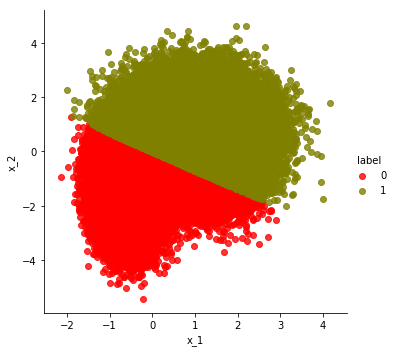

In [11]:
# Test cell: `kmeans_test`

# Calculate the estimated centers
centers_est = update_centers(k, points, clustering)
print("\n=== Estimated centers ===\n{}".format(centers_est))
print("\n=== True centers ===\n{}".format(centers_true))

n_matches = count_matches(labels, clustering)
print("\n{} matches out of {} possible (~ {:.1f}%)".format(n_matches, n, 100.0*n_matches/n))

visualize_clusters(points, clustering)

# Profiling

What is (or are) the bottleneck(s) in this code? Let's use Python's [`line_profiler`](https://jakevdp.github.io/PythonDataScienceHandbook/01.07-timing-and-profiling.html) to find out.

In [12]:
%load_ext line_profiler

In [13]:
%lprun -f kmeans kmeans(points, k, starting_centers=points[[0, 187], :], max_steps=50)

**Observation.** You should have seen that there are two bottlenecks: computing the sum-of-squared distances and updating the centers.

Let's use Intrepydd to try to improve the performance of the latter. Then, as an exercise for you, try optimizing the former.

> Before we begin, estimate how much faster you can go, ideally, by improving `update_centers__0`. A quick-and-dirty method is to use [Amdahl's Law](https://en.wikipedia.org/wiki/Amdahl%27s_law). That is, suppose that the profiler shows that `update_centers__0` takes 60% of the total execution time. Further suppose that, magically, we can shrink that time to zero, while the time to perform all other steps remains the same. Then, the new time will be 100% - 60% = 40% of the original time. The **_speedup_**, or ratio of the time before to the time after, is 100% / 40% = 2.5. In other words, the improved time will never be more than two-and-a-half times faster than the original time, all other parts of the program remaining as they are.

## Intrepydd reimplementation ##

In Intrepydd v0.1, you'll need to write a "scalar" version of the original array-based code. Here is one such implementation. Notice that it has an identical signature as `update_centers__0`, meaning we should be able to "drop it in" as a direct substitute for the original algorithm.

Take a moment to study the code to see that you follow it's steps, then read the explanation below for what it does to try to speed up the original code.

In [14]:
%%writefile opt.pydd
# opt.pydd

def update_centers(k: int64, X: Array(float64, 2), y: Array(int64)) -> Array(float64, 2):
    m = shape(X, 0) # type: int64
    d = shape(X, 1) # type: int64
    centers = zeros((k, d))
    counts = zeros(k) # @todo: need dtype = int64
    
    # Sum each coordinate for each cluster
    # and count the number of points per cluster
    for i in range(m):
        c = y[i] # type: int64
        counts[c] += 1
        for j in range(d):
            centers[c, j] += X[i, j]
            
    # Divide the sums by the number of points
    # to get the average
    for c in range(k):
        n_c = counts[c] # type: int64
        for j in range(d):
            centers[c, j] /= n_c
    return centers

# eof

Overwriting opt.pydd


**Performance improvement techniques.** This Intrepydd-based implementation tries to do several things to improve the original code.

First, this new code is explicit about types. This information allows Intrepydd to generate more specialized (and presumably faster) code.

Secondly, it uses a better "algorithm" or procedure, in particular, by making fewer passes over the data. Recall the original code:

```python
    centers = numpy.zeros((k, d))
    for j in range(k):
        centers[j, :d] = numpy.mean(X[y == j, :], axis=0)
    return centers
```

Notice that it loops over the entire dataset, `X` and `y`, **once per cluster**, or `k=2` times in total. The expression, `X[y == j, :]` extracts all rows of `X` that match the label `j`, which requires one pass over `X`; since `j` ranges from 0 to `k-1=2-1=1`, or two times, then the original loop must make two passes over the data.

By contrast, the new version only makes **one** pass over `X` and `y`, in the first loop nest (lines 12-16). The original code is more "Pythonic," but the Intrepydd code effectively.

**Compile using Intrepydd:**

In [15]:
!pyddc opt.pydd

**Initial test.** The following cell runs the Intrepydd version. You should observe identical (or nearly identical) convergence behavior of the Intrepydd version is correct.

> The phrase "_nearly identical_" refers to the fact that, due to floating-point roundoff errors, there may be slight differences in the calculation. That's because the Intrepydd version might reordering operations and parallelize as part of trying to speed up your code.

In [16]:
import opt
update_centers = opt.update_centers
kmeans(points, k, starting_centers=points[[0, 187], :], max_steps=50, verbose=True)

iteration 1 WCSS =  426970.8626664304
iteration 2 WCSS =  226310.09345734873
iteration 3 WCSS =  224407.17701506524
iteration 4 WCSS =  224018.7707821729
iteration 5 WCSS =  223922.27914028172
iteration 6 WCSS =  223896.31847496447
iteration 7 WCSS =  223888.81094381658
iteration 8 WCSS =  223886.6937343472
iteration 9 WCSS =  223886.15238068666
iteration 10 WCSS =  223886.0324247049
iteration 11 WCSS =  223886.0143275342
iteration 12 WCSS =  223886.0126421413
iteration 13 WCSS =  223886.01211948472
iteration 14 WCSS =  223886.01193380076
iteration 15 WCSS =  223886.01182774224
iteration 16 WCSS =  223886.0117825087


array([0, 0, 0, ..., 1, 1, 1])

**Profile run.** Let's re-run the profiler to see if the bottleneck sped up at all.

In [17]:
%lprun -f kmeans kmeans(points, k, starting_centers=points[[0, 187], :], max_steps=50)

In [18]:
update_centers, compute_d2 = update_centers__0, compute_d2__0
t_0 = %timeit -o kmeans(points, k, starting_centers=points[[0, 187], :], max_steps=50)

update_centers, compute_d2 = opt.update_centers, compute_d2__0
t_opt = %timeit -o kmeans(points, k, starting_centers=points[[0, 187], :], max_steps=50)

print("\n==> Speedup is ~{:.2f}x".format(t_0.average / t_opt.average))

1.8 s ± 104 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
960 ms ± 119 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

==> Speedup is ~1.88x


How does this speedup compare to the ideal speedup you estimated above?

## Exercise: Improve the squared-distance computations ##

Recall that a second bottleneck is the computation of squared distances. Try replicating the basic development procedure above to see if you can obtain a speedup using Intrepydd. To help you get started, here is the original implementation as a reminder, as well as a placeholder for your Intrepydd code and some timing code. Good luck!

```python
    # Original implementation, for your reference
    def compute_d2__0(X, centers):
        return numpy.linalg.norm(X[:, numpy.newaxis, :] - centers, ord=2, axis=2) ** 2
```

In [19]:
%%writefile opt_d2.pydd
# opt_d2.pydd

def compute_d2(X: Array(float64, 2), centers: Array(float64, 2)) -> Array(float64, 2):
    m = shape(X, 0) # type: int64
    d = shape(X, 1) # type: int64
    k = shape(centers, 0) # type: int64
    
    # Place your Intrepydd implementation here
    D2 = zeros((m, k))
    ###
    ### YOUR CODE HERE
    ###
    return D2

# eof

Overwriting opt_d2.pydd


**Hint.** If you get stuck, we've placed a sample solution in the file, [`./opt_d2_soln.pydd`](./opt_d2_soln.pydd).

In [20]:
!pyddc opt_d2.pydd

In [21]:
# Test run. Make sure the convergence of `WCSS` looks the same.
import opt_d2
compute_d2 = opt_d2.compute_d2
kmeans(points, k, starting_centers=points[[0, 187], :], max_steps=50, verbose=True)

iteration 1 WCSS =  426970.8626664305
iteration 2 WCSS =  226310.09345734873
iteration 3 WCSS =  224407.17701506524
iteration 4 WCSS =  224018.7707821729
iteration 5 WCSS =  223922.27914028172
iteration 6 WCSS =  223896.31847496447
iteration 7 WCSS =  223888.81094381658
iteration 8 WCSS =  223886.69373434718
iteration 9 WCSS =  223886.15238068666
iteration 10 WCSS =  223886.0324247049
iteration 11 WCSS =  223886.0143275342
iteration 12 WCSS =  223886.0126421413
iteration 13 WCSS =  223886.01211948472
iteration 14 WCSS =  223886.01193380076
iteration 15 WCSS =  223886.0118277423
iteration 16 WCSS =  223886.0117825087


array([0, 0, 0, ..., 1, 1, 1])

In [22]:
# Timing run using `line_profiler`
update_centers, compute_d2 = opt.update_centers, opt_d2.compute_d2
%lprun -f kmeans kmeans(points, k, starting_centers=points[[0, 187], :], max_steps=50)

In [23]:
# Testing run using %timeit
update_centers, compute_d2 = opt.update_centers, opt_d2.compute_d2
t_opt_d2 = %timeit -o kmeans(points, k, starting_centers=points[[0, 187], :], max_steps=50)

print("\n==> Speedup is ~{:.2f}x".format(t_0.average / t_opt_d2.average))

731 ms ± 6.21 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

==> Speedup is ~2.47x


## Summary ##

This example is designed to show you how to construct and optimize a larger workflow using a canonical algorithm, the Lloyd's k-means algorithm. Some good practices to observe:

- Get a working solution and use profiling to help triage performance bottlenecks.
- Use aliasing to help swap different implementations.
- When trying to improve performance, look for opportunities to specialize types and reduce the number of passes through the data